In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV,train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

### Data Loading

In [2]:
df = pd.read_csv("diabetes_012_health_indicators_BRFSS2015.csv")
df.dropna(inplace=True)
diabetes = df['Diabetes_012']
df.drop(columns=['Diabetes_012'],inplace=True)
df["Diabetes_012"] = diabetes
df.head(10)

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income,Diabetes_012
0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0,0.0
1,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0,0.0
2,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0,0.0
3,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0,0.0
4,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0,0.0
5,1.0,1.0,1.0,25.0,1.0,0.0,0.0,1.0,1.0,1.0,...,0.0,2.0,0.0,2.0,0.0,1.0,10.0,6.0,8.0,0.0
6,1.0,0.0,1.0,30.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,0.0,14.0,0.0,0.0,9.0,6.0,7.0,0.0
7,1.0,1.0,1.0,25.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,3.0,0.0,0.0,1.0,0.0,11.0,4.0,4.0,0.0
8,1.0,1.0,1.0,30.0,1.0,0.0,1.0,0.0,1.0,1.0,...,0.0,5.0,30.0,30.0,1.0,0.0,9.0,5.0,1.0,2.0
9,0.0,0.0,1.0,24.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,2.0,0.0,0.0,0.0,1.0,8.0,4.0,3.0,0.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   HighBP                253680 non-null  float64
 1   HighChol              253680 non-null  float64
 2   CholCheck             253680 non-null  float64
 3   BMI                   253680 non-null  float64
 4   Smoker                253680 non-null  float64
 5   Stroke                253680 non-null  float64
 6   HeartDiseaseorAttack  253680 non-null  float64
 7   PhysActivity          253680 non-null  float64
 8   Fruits                253680 non-null  float64
 9   Veggies               253680 non-null  float64
 10  HvyAlcoholConsump     253680 non-null  float64
 11  AnyHealthcare         253680 non-null  float64
 12  NoDocbcCost           253680 non-null  float64
 13  GenHlth               253680 non-null  float64
 14  MentHlth              253680 non-null  float64
 15  

### Distribution of Diabetes

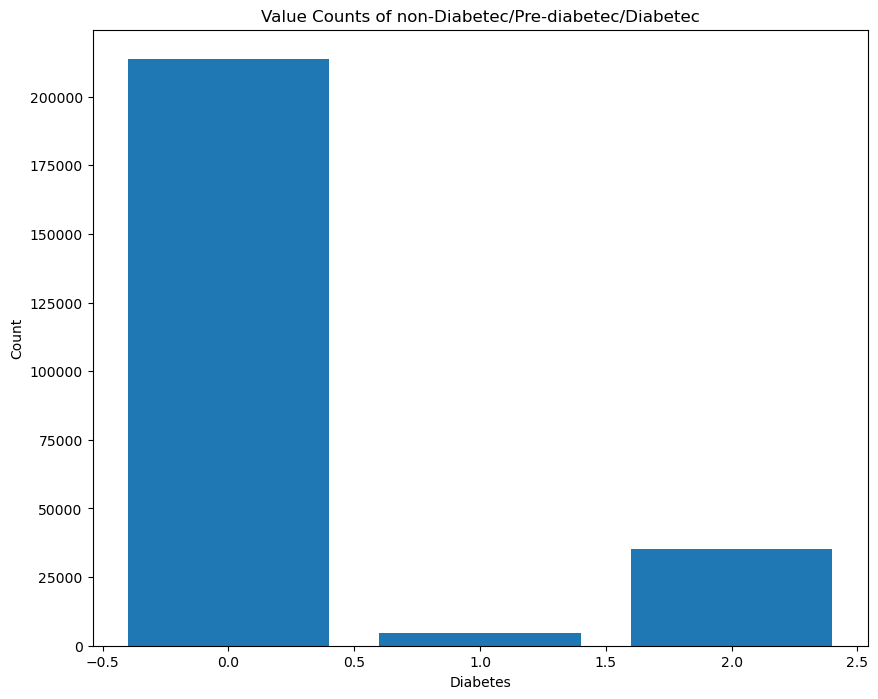

In [15]:
value_counts = df.Diabetes_012.value_counts()

plt.figure(figsize=(10, 8))
plt.bar(value_counts.index, value_counts.values)
plt.xlabel('Diabetes')
plt.ylabel('Count')
plt.title('Value Counts of non-Diabetec/Pre-diabetec/Diabetec')
plt.show()

### Feature selection

<Axes: >

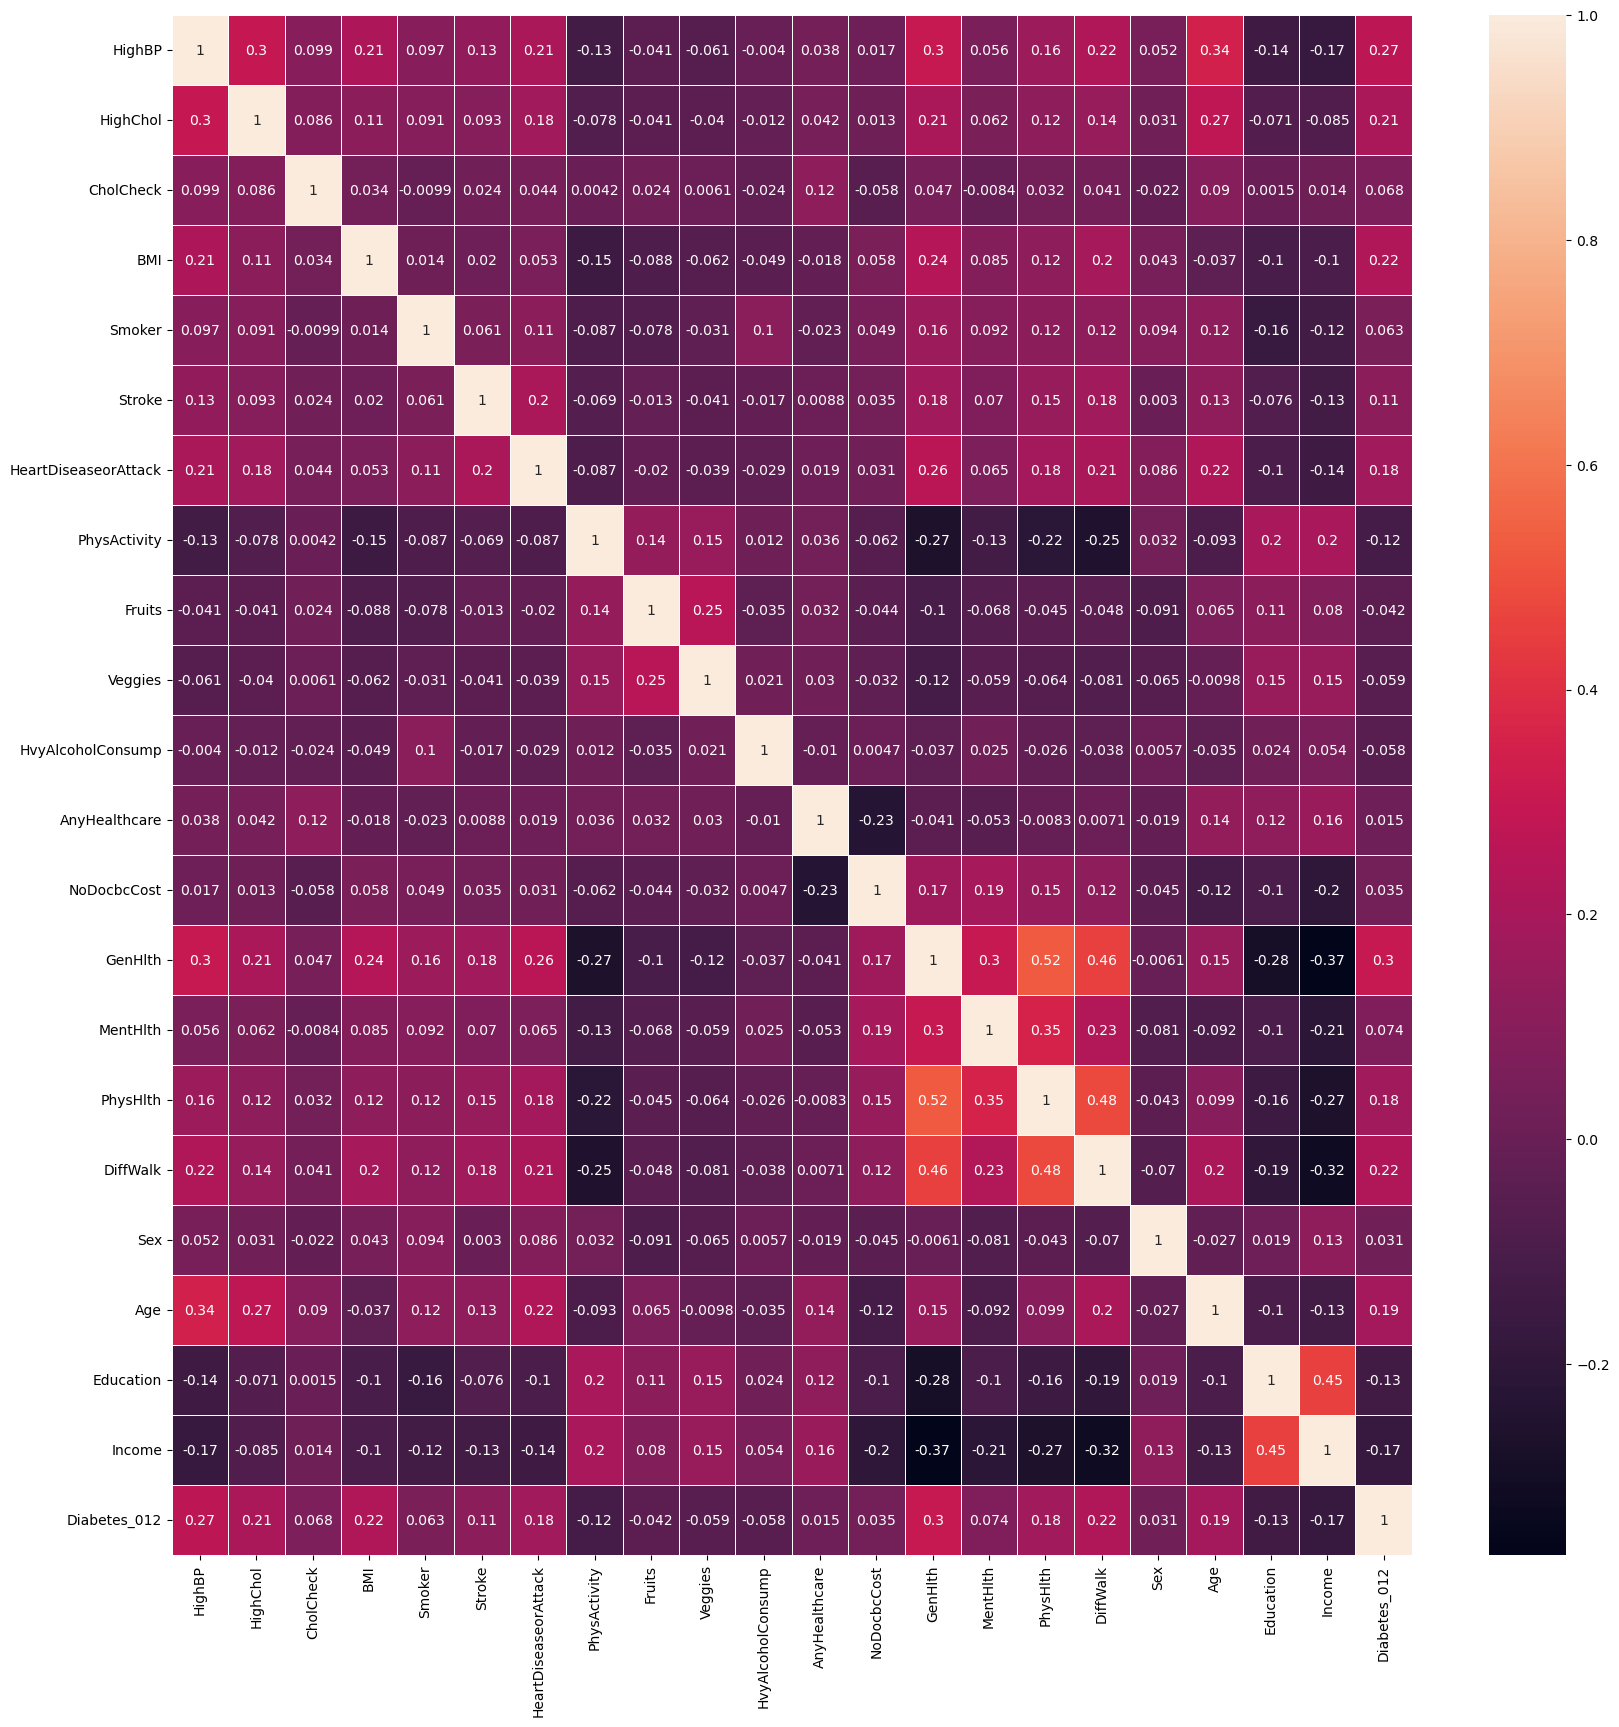

In [5]:
fig, ax = plt.subplots(figsize=(20,20))        
sns.heatmap(df.corr(), annot=True, linewidths=.5, ax=ax)

We remove the features that are not correlated with the target variable as they may not be indicative of the diabetes. Then we remove the features that are correlated with each other.

<Axes: >

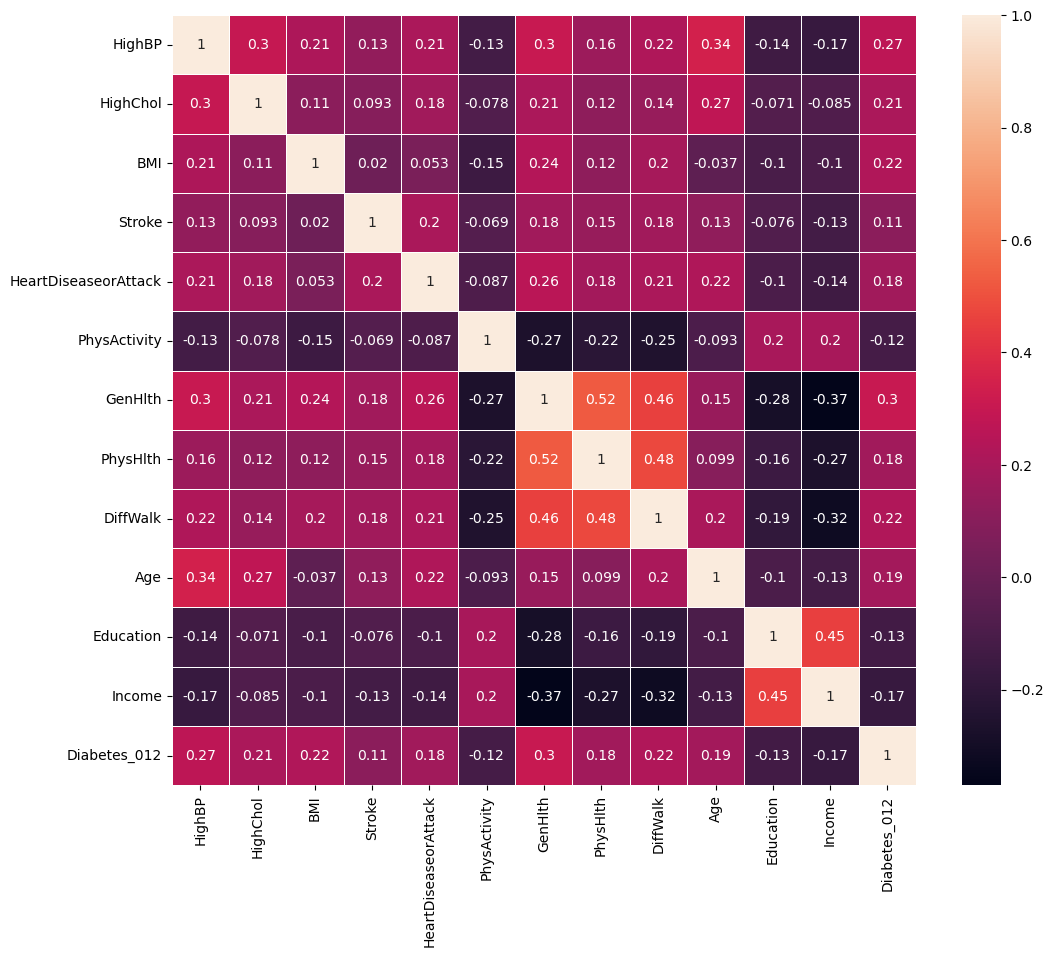

In [6]:
filter = ["HighBP","HighChol","BMI","Stroke","HeartDiseaseorAttack","PhysActivity","GenHlth","PhysHlth","DiffWalk","Age","Education","Income","Diabetes_012"]

fig, ax = plt.subplots(figsize=(12,10))        
sns.heatmap(df[filter].corr(), annot=True, linewidths=.5, ax=ax)

In [7]:
features_selected = ["HighBP","HighChol","BMI","Stroke","HeartDiseaseorAttack","PhysActivity","PhysHlth","Age","Education"]
X = df[features_selected]
y = df["Diabetes_012"]

#Create train and test splits

#stratrifying the data because of imabalance of y values in dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=37, stratify=y)

### XGBoost classifier

In [17]:
#creating the parameter grid for selecting the best hyperparameters for the XGB classifier

param_grid = {
            'learning_rate': [0.1,0.05,0.2], 
              'min_child_weight':[3,5,7], 
              'eval_metric':['error'],
              'max_depth':[3,5,7],
              'lambda': [0.01,0.05],
              'alpha':[0.01,0.05]
              }

model = xgb.XGBClassifier(objective="multi:softprob", random_state=37)

In [18]:
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=10, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Output the best parameters and the best score
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

best_score

0.8477215272238718

In [19]:
best_model

XGBClassifier(alpha=0.01, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='error', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=0.01, learning_rate=0.1,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=7, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, ...)

In [20]:
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.86      0.98      0.92     64111
         1.0       0.00      0.00      0.00      1389
         2.0       0.56      0.14      0.23     10604

    accuracy                           0.85     76104
   macro avg       0.47      0.37      0.38     76104
weighted avg       0.80      0.85      0.80     76104



c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
def plot_imp_features(cols, fimp):
    data = pd.DataFrame({'Feature': cols, 'Importance': fimp})
    data = data.sort_values('Importance', ascending=False)
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Importance', y='Feature', data=data)
    plt.ylabel('Features', fontsize=14)
    plt.xlabel('Importance', fontsize=14)
    plt.title('Feature Importances', fontsize=16)
    plt.yticks(rotation=0, fontsize=12)
    plt.tight_layout()
    plt.show()

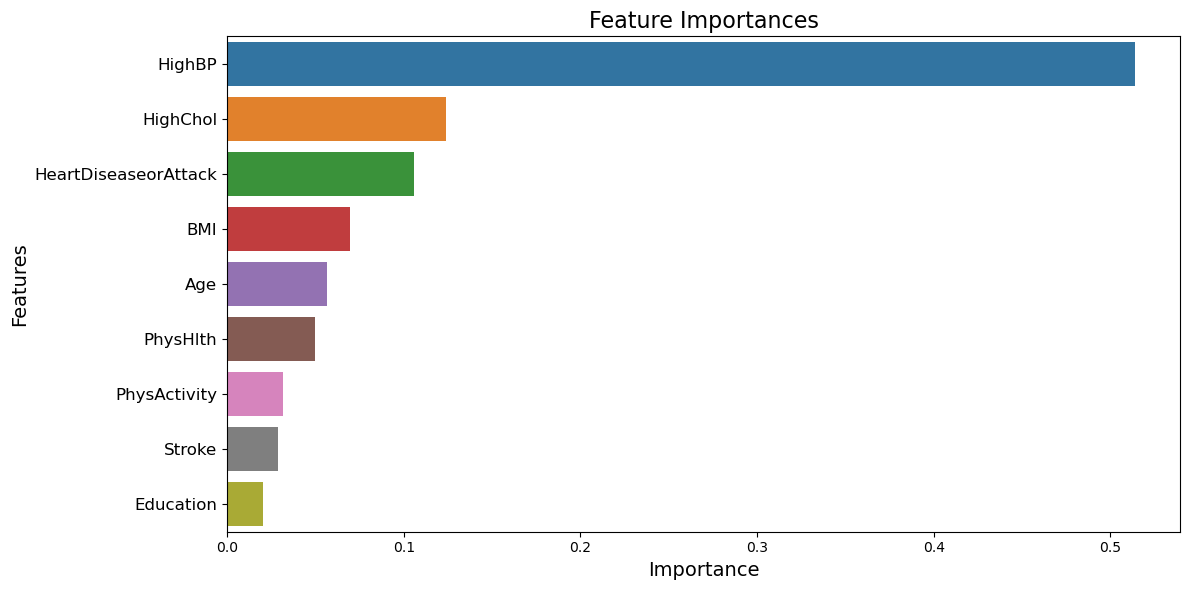

In [22]:
plot_imp_features(X.columns,best_model.feature_importances_)